GPX for Three.js
===
---

In [1]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
name = "./static/yamap_2017-12-04_08_20.gpx"
with open(name, "r") as f:
    gpx = f.read()
soup = BeautifulSoup(gpx)

/usr/local/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [3]:
out = [{"lat": float(t.get("lat")), "lon": float(t.get("lon")), "ele": float(t.ele.string)}\
       for t in soup.find_all("trkpt")]
print(len(out), "\n", out[0])

104 
 {'lat': 35.4317330243396, 'lon': 139.149259748067, 'ele': 660.370975494385}


In [4]:
# https://github.com/sw1227/geospatial_analysis/blob/master/geo_util.py
# -*- coding: utf-8 -*-

import pandas as pd
import requests
import urllib.error
from io import BytesIO
import numpy as np
from PIL import Image


class MapTile():
    """ 座標・タイルの種類をもとに地理院タイルを取得して保持するクラス """

    def __init__(self, from_tile, to_tile=None, zoom=None, tile_type="std", ext="png"):
        """ Constructor
        Input
        -----
          from_tile : 取得したい領域内の左上のタイル座標[z, x, y]
          to_tile   : 取得したい領域内の右下のタイル座標[z, x, y] : 単一タイルの時省略可
          zoom      : ズームレベル(from_tile, to_tileのzと異なるズームレベルで取得したければ)
          tile_type : 取得したいタイルの種類
          ext       : 取得したいタイルの拡張子
        Attribute
        ---------
          data  : 取得した地理院タイル(Numpy Array)
          shape : self.dataのshape
        """
        self.from_tile = from_tile
        self.to_tile = to_tile
        self.zoom = zoom
        self.tile_type = tile_type
        self.ext = ext

        # zoomを省略するとfrom_tileと同じになる
        if zoom == None:
            zoom =from_tile[0]

        # to_tileを省略するとfrom_tileと同じになる
        if to_tile == None:
            to_tile = from_tile

        # 地理院タイルのズームレベルの限界
        MAX_ZOOM = 18
        assert zoom <= MAX_ZOOM

        # 指定された領域・ズームレベルおける最も左上のタイル座標
        x1 = from_tile[1] * 2**(zoom - from_tile[0])
        y1 = from_tile[2] * 2**(zoom - from_tile[0])
        # 指定された領域・ズームレベルにおける最も右下のタイル座標
        x2 = (to_tile[1] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
        y2 = (to_tile[2] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1

        # 左上〜右下すべてのタイルの座標を計算
        tile_list = []
        for j in range(y1, y2+1):
            tile_row = []
            for i in range(x1, x2+1):
                tile_row.append([zoom, i, j])
            tile_list.append(tile_row)

        # タイルをダウンロードしてself.dataにセット
        full_tile = []
        for tile_row in tile_list:
            tr = []
            for tile in tile_row:
                tile_url = "http://cyberjapandata.gsi.go.jp/xyz/{tile_type}/{z}/{x}/{y}.{ext}"\
                           .format(tile_type=tile_type, z=tile[0], x=tile[1], y=tile[2], ext=ext)
                if ext in ["png", "jpg"]:
                    # 画像の場合
                    try:
                        response = requests.get(tile_url)
                        img_arr = np.array(Image.open(BytesIO(response.content)))
                    except urllib.error.HTTPError:
                        img_arr = np.zeros((256, 256, 3))
                    tr.append(img_arr)
                elif ext == "txt":
                    # 標高csvの場合
                    try:
                        df = pd.read_csv(tile_url, header=None).replace("e", 0)  # 海: "e" -> 0
                        csv_arr = df.values.astype(np.float)  # numpy array
                    except urllib.error.HTTPError:
                        csv_arr = np.zeros((256, 256))
                    tr.append(csv_arr)
                else:
                    raise ValueError("only {.jpg, .png, .txt} supported")
            tr = np.array(tr)
            full_tile.append(np.hstack(tr))
        self.data = np.vstack(np.array(full_tile))
        self.shape = self.data.shape


    def grad(self, x, y):
        """ 指定された地点での勾配を計算する
        Input
        -----
          x, y: 勾配を計算したい地点の座標
        Output
        -----
          grad_x, grad_y: 勾配のx, y成分
        """
        fx, fy = int(x), int(y) # floor
        dx, dy = x-int(x), y-int(y) # decimal part
        if (dx + dy) < 1:
            grad_x = self.data[fy, fx+1] - self.data[fy, fx]
            grad_y = self.data[fy+1, fx] - self.data[fy, fx]
        else:
            grad_x = self.data[fy+1, fx+1] - self.data[fy+1, fx]
            grad_y = self.data[fy+1, fx+1] - self.data[fy, fx+1]
        return grad_x, grad_y
    
    def grad_norm(self, x, y):
        """ 指定された地点での勾配の大きさを計算する """
        gx, gy = self.grad(x, y)
        return np.sqrt(gx**2 + gy**2)

    def grad_angle(self, x, y):
        """ 指定された地点での勾配の角度を計算する """
        gx, gy = self.grad(x, y)
        return np.arctan2(gy, gx)

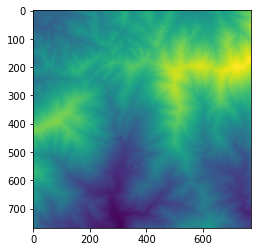

In [36]:
from_tile, to_tile = [15, 29047, 12929], [15, 29049, 12931]
nabewari_tile = MapTile(from_tile, to_tile, zoom=15, tile_type="dem5a", ext="txt")
nabewari_map = MapTile(from_tile, to_tile, zoom=15, tile_type="std", ext="png")
plt.imshow(nabewari_tile.data)

- 標高データをjsで読むために表示する。
- コピペしてnabewari_dem=[...]みたいにする

In [14]:
nabewari_tile.shape

(768, 768)

In [15]:
flat = nabewari_tile.data.flatten()

In [23]:
np.savetxt("test.txt", flat, newline=",", fmt="%.2f")

鍋割山稜Noと山荘の位置をindexに対応させる

In [25]:
# http://www.trail-note.net/tech/coordinate/
def latlon_to_pixel(lat, lon, zoom):
    L = 85.05112878
    x = 2**(zoom+7) * (1 + lon/180.)
    y = 2**(zoom+7) / np.pi * (- np.arctanh(np.sin(np.pi*lat/180.)) + np.arctanh(np.sin(np.pi*L/180.)))
    return x, y

In [27]:
n_lat, n_lon = 35.443923,139.141612  # 鍋割山荘
px, py = latlon_to_pixel(n_lat, n_lon, 15)
print(px, py)
print(px - 256*from_tile[1], py-256*from_tile[2]) # これをjs内にコピペ

7436538.554322489 3310047.04851
506.554322488606 223.048505018


In [32]:
#  鍋割山稜2 - 10
numbers = [[35.43203333333334, 139.1488945], [35.431705, 139.148025], [35.43167166666667, 139.1444083333333], 
           [35.430875, 139.1437083333333], [35.43199166666667, 139.14305], [35.43361666666667, 139.1429278333333],
           [35.43595, 139.1413721666667], [35.43785, 139.1417528333333], [35.438795, 139.141875]]
# indexと対応させる
pixels = []
for n in numbers:
    px, py = latlon_to_pixel(n[0], n[1], 15)
    pixels.append([px - 256*from_tile[1], py - 256*from_tile[2]])
pixels # これをjsにコピペ

[[676.2488718219101, 563.09327472373843],
 [655.9880533330142, 572.48290397040546],
 [571.713611850515, 573.43616368295625],
 [555.4024296291173, 596.2189533864148],
 [540.0621511107311, 564.2848541601561],
 [537.2154614506289, 517.8127992618829],
 [500.96580077148974, 451.08205462712795],
 [509.8359770067036, 396.74273407971486],
 [512.6826666668057, 369.71559449797496]]

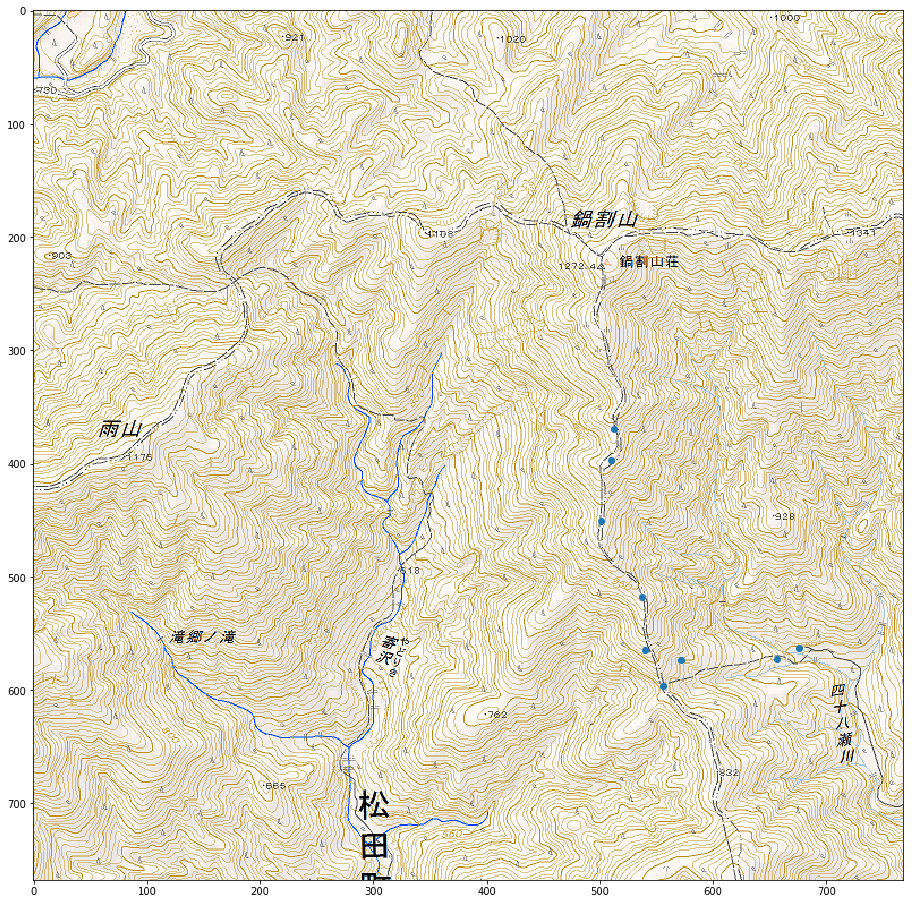

In [37]:
figsize(16, 16)
pixels=np.array(pixels)
plt.scatter(pixels[:, 0], pixels[:, 1])
plt.imshow(nabewari_map.data)

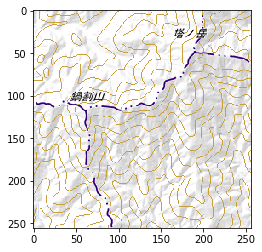

In [5]:
nabewari_img = MapTile([13, 7262, 3232], tile_type="std", ext="png")
figsize(4, 4)
plt.imshow(nabewari_img.data)

In [7]:
latlon_to_pixel(45.178506, 141.242035, 17)

(29941927.83041422, 12046802.886155611)

In [8]:
n_lat, n_lon = 35.443923,139.141612  # 鍋割山荘
px, py = latlon_to_pixel(n_lat, n_lon, 13)
print(px, py)
print(px%256, py%256)

1859134.6385806222 827511.762126
62.638580622151494 119.762126254


In [10]:
#  鍋割山稜2 - 10
numbers = [[35.43203333333334, 139.1488945], [35.431705, 139.148025], [35.43167166666667, 139.1444083333333], 
           [35.430875, 139.1437083333333], [35.43199166666667, 139.14305], [35.43361666666667, 139.1429278333333],
           [35.43595, 139.1413721666667], [35.43785, 139.1417528333333], [35.438795, 139.141875]]

In [15]:
# indexと対応させる
hoge = []
for n in numbers:
    lat, lon = latlon_to_pixel(n[0], n[1], 13)
    hoge.append([lat%256, lon%256])
hoge

[[105.06221795547754, 204.77331868093461],
 [99.99701333325356, 207.12072599260136],
 [78.92840296262875, 207.35904092073906],
 [74.85060740727931, 213.0547383466037],
 [71.01553777768277, 205.07121354003903],
 [70.30386536265723, 193.45319981547073],
 [61.241450192872435, 176.77051365678199],
 [63.458994251675904, 163.18568351992872],
 [64.17066666670144, 156.42889862449374]]

In [17]:
hoge = np.array(hoge)
hoge[:, 0]

array([ 105.06221796,   99.99701333,   78.92840296,   74.85060741,
         71.01553778,   70.30386536,   61.24145019,   63.45899425,
         64.17066667])

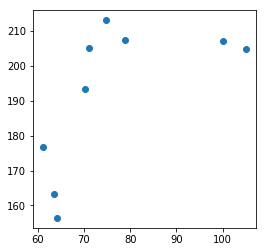

In [18]:
plt.scatter(hoge[:, 0], hoge[:, 1])

In [40]:
nabewari_img.shape

(256, 256, 3)

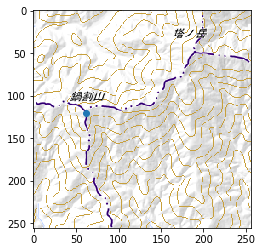

In [13]:
plt.imshow(nabewari_img.data)
plt.scatter(62, 120)

- いい感じ！

In [19]:
trail = [latlon_to_pixel(t["lat"], t["lon"], 13) for t in out]
trail = np.array(trail)
trail = trail % 256
trail[:5]

array([[ 107.18994216,  206.92036736],
       [ 105.85937575,  206.92036736],
       [ 104.6210945 ,  207.39468156],
       [ 103.74462966,  208.36817801],
       [ 102.45849685,  208.41282278]])

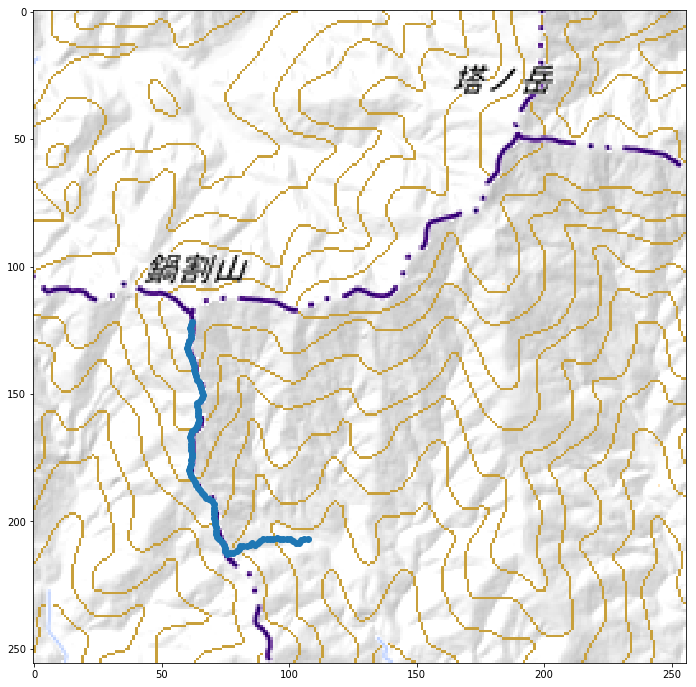

In [25]:
figsize(12, 12)
plt.imshow(nabewari_img.data)
plt.scatter(trail[:, 0], trail[:, 1])

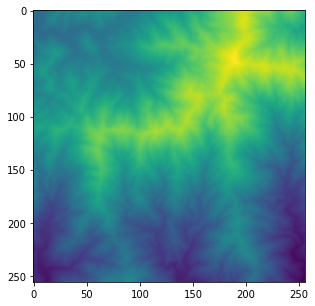

In [30]:
figsize(5,5)
nabewari_dem = MapTile([13, 7262, 3232], tile_type="dem", ext="txt")
plt.imshow(nabewari_dem.data)

In [37]:
np.savetxt("dem.js", nabewari_dem.data.flatten(), delimiter=",", newline=",")

In [32]:
print(nabewari_dem.data.min(), nabewari_dem.data.max())

400.38 1490.42


In [41]:
out

[{'ele': 660.370975494385, 'lat': 35.4317330243396, 'lon': 139.149259748067},
 {'ele': 657.59534072876, 'lat': 35.4317330243396, 'lon': 139.149031341205},
 {'ele': 655.475589752197, 'lat': 35.431666681576, 'lon': 139.148818776141},
 {'ele': 665.038822174072, 'lat': 35.431530517559, 'lon': 139.148668320979},
 {'ele': 668.425052642822, 'lat': 35.4315242730411, 'lon': 139.14844754165},
 {'ele': 676.214603424072, 'lat': 35.4316013027313, 'lon': 139.148246795069},
 {'ele': 674.839115142822, 'lat': 35.4317075852635, 'lon': 139.148065494503},
 {'ele': 680.812015533447, 'lat': 35.4317282466548, 'lon': 139.147844966631},
 {'ele': 688.532230377197, 'lat': 35.4317396879526, 'lon': 139.147619325797},
 {'ele': 695.738285064697, 'lat': 35.431752637993, 'lon': 139.14739318205},
 {'ele': 703.36145401001, 'lat': 35.4317690665232, 'lon': 139.147170558701},
 {'ele': 703.71057510376, 'lat': 35.4317305935877, 'lon': 139.146954137962},
 {'ele': 710.079105377197, 'lat': 35.4317271150979, 'lon': 139.146730927

In [ ]:
trail = [latlon_to_pixel(t["lat"], t["lon"], 13) for t in out]
trail = np.array(trail)
trail = trail % 256
trail[:5]

In [43]:
trail = []
for t in soup.find_all("trkpt"):
    x, y = latlon_to_pixel(float(t.get("lat")), float(t.get("lon")), 13)
    x, y = x%256, y%256
    d = {"x": x, "y": y, "ele": float(t.ele.string)}
    trail.append(d)
trail

[{'ele': 660.370975494385, 'x': 107.18994216178544, 'y': 206.92036736209411},
 {'ele': 657.59534072876, 'x': 105.85937575204298, 'y': 206.92036736209411},
 {'ele': 655.475589752197, 'x': 104.62109450460412, 'y': 207.39468155789655},
 {'ele': 665.038822174072, 'x': 103.74462966038845, 'y': 208.36817801021971},
 {'ele': 668.425052642822, 'x': 102.45849685091525, 'y': 208.4128227760084},
 {'ele': 676.214603424072, 'x': 101.28906325716525, 'y': 207.86210388236213},
 {'ele': 674.839115142822, 'x': 100.23291091085412, 'y': 207.10224278201349},
 {'ele': 680.812015533447, 'x': 98.94824294466525, 'y': 206.95452518842649},
 {'ele': 688.532230377197, 'x': 97.6337898161728, 'y': 206.87272618012503},
 {'ele': 695.738285064697, 'x': 96.31640700693242, 'y': 206.78014047536999},
 {'ele': 703.36145401001, 'x': 95.01953200250864, 'y': 206.66268544981722},
 {'ele': 703.71057510376, 'x': 93.75878982036375, 'y': 206.93774590536486},
 {'ele': 710.079105377197, 'x': 92.45849684812129, 'y': 206.96261519927066